# Homework #7. kNN, K-Means

## Task #1

К алгоритму kNN, представленному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [107]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [108]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y, test_size=0.2, random_state=9)

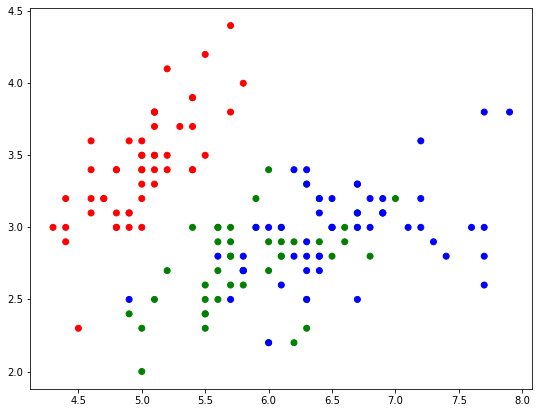

In [109]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(9, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [110]:
def e_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [111]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [112]:
def calc_dist_weight(distance, q):
    return q ** distance

In [ ]:
def calc_dist_weight_2()

In [113]:
def knn(X_train, y_train, X_test, k, q):
    
    preds = []
    for x in X_test:
        test_distances = []
        classes = {class_item: 0 for class_item in set(y_train)}
        for i in range(len(X_train)):
            distance = e_metrics(x, X_train[i])
            
            test_distances.append((distance, y_train[i]))      
        
        for distance in sorted(test_distances)[0:k]:
            classes[distance[1]] += calc_dist_weight(distance[0], q)
        
        preds.append(sorted(classes, key=classes.get)[-1])
    
    return preds

In [114]:
ks = np.arange(1, 11)

In [115]:
for k in ks:
    y_pred = knn(X_train, y_train, X_test, k, 1)
    acc = accuracy(y_pred, y_test)
    print(f'k = {k}: accuracy = {acc:.3f}')

k = 1: accuracy = 0.800
k = 2: accuracy = 0.833
k = 3: accuracy = 0.900
k = 4: accuracy = 0.900
k = 5: accuracy = 0.900
k = 6: accuracy = 0.900
k = 7: accuracy = 0.900
k = 8: accuracy = 0.900
k = 9: accuracy = 0.900
k = 10: accuracy = 0.967


In [120]:
def get_graph(X_train, y_train, k, q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()
    

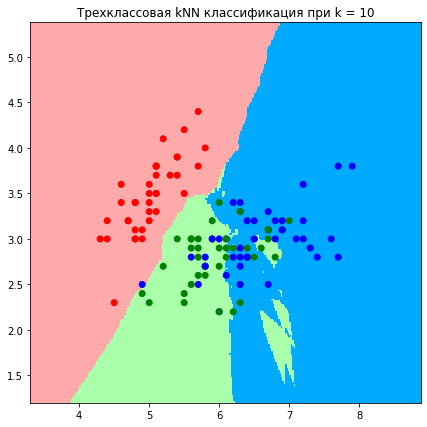

In [122]:
get_graph(X_train, y_train, k=10, q=1)